## Imports

In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import pickle

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image
from bin.saving_datasets_for_Statistician import create_dataset

c:\Anaconda\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


## Data-Handling

In [2]:
# Data handling constants
TRAIN_DIR = './data_map_cutouts/train3' 
BATCH_SIZE = 128

In [3]:
# The actual Data handling

# Some transformations to apply to the dataset
to_tensor = transforms.ToTensor()                       # Convert it to a tensor
random_flips_v = transforms.RandomVerticalFlip(0.5)     # Flip it vertically with prob. 0.5
random_flips_h = transforms.RandomHorizontalFlip(0.5)   # Flip it horizontally with prob 0.5
to_grayscale = transforms.Grayscale(1)                  # Convert the image to a single channel image

# Composing the transformations
transform = transforms.Compose([
    to_grayscale,
    to_tensor,
    random_flips_h,
    random_flips_v
])

# Creating the dataLoader
train_dir = pathlib.Path(TRAIN_DIR)                         # The directory 
train_data = datasets.ImageFolder(root      = train_dir,    # The dataset
                                  transform = transform)
train_dataLoader = DataLoader(dataset = train_data,         # The dataLoader (batches and shuffles the data)
                     batch_size = BATCH_SIZE, 
                     shuffle    = True,
                     drop_last  = True)


Shape of images from dataLoader: torch.Size([128, 1, 128, 128])


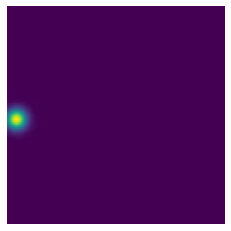

In [4]:
# Sampling from the dataset
images, labels = next(iter(train_dataLoader))
print("Shape of images from dataLoader:", images.shape)

# Displaying a sample input image
plt.imshow(images[0, 0, :, :].detach().cpu().numpy())
plt.axis('off')
plt.show()

## DCGAN

In [5]:
# ---------- IMPORTANT CONSTANTS ----------
# Model Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_DIM = 2

# Training parameters
N_EPOCHS = 100
N_CRITICS = 5
SAMPLE_INTERVALS = 100
SAVE_INTERVAL = 50
DUMPING_INTERVAL = 1000
LEARNING_RATE = 1e-4
BETAS = (0.5, 0.9)
L_GP = 5.0     # Weight of the Gradient Policy cost
L_l1 = 0.0      # Weight of the L1 norm cost

# Data handling
SAVING_DIR = 'datasets_for_Statistician/single_Gaussian_Blobs_DCGAN/generated_data/' 
os.makedirs(SAVING_DIR, exist_ok=True)
BATCHES_TO_SAVE = 5


In [6]:
# ---------- SOME IMPORTANT LAYERS ----------
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
        # print(shape)

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)


class LinearFeature(nn.Module):
    __constants__ = ['in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(LinearFeature, self).__init__()
        assert(out_features == in_features)
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.normal_(self.weight,1,0.02)
        if self.bias is not None:
            nn.init.normal_(self.bias,0,0.02)
    
    def forward(self, input):
        device = torch.device("cuda" if input.is_cuda else "cpu")
        eye = nn.Parameter(torch.zeros(input.shape), requires_grad=False).to(device=device)
        idxes = np.arange(input.shape[-1])
        eye[...,idxes, idxes] = 1.
        mat_weight = torch.einsum("i,...ijk->...ijk", self.weight, eye)

        if self.bias is not None:
            ones = nn.Parameter(torch.ones(input.shape), requires_grad=False).to(device=device)
            mat_bias = torch.einsum("i,...ijk->...ijk", self.bias, ones)

        return torch.matmul(input,mat_weight) if self.bias is None else torch.matmul(input,mat_weight) + mat_bias 

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class ScaledTanh(nn.Module):
    def __init__(self, a=15., b=2. / 15.):
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, sample):
        return torch.tanh(sample * self.b) * self.a

In [7]:
class Generator_Basic(nn.Module):
    def __init__(self, ngpu = 1, latent_dim = 100) -> None:
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 1024*4**2),
            Reshape((1024, 4, 4))
        )

        self.convT1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024,
                out_channels=512,
                kernel_size=4,
                stride = 2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=512,
                           eps=0.01,
                           momentum=0.9),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.convT2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 512,
                out_channels = 256,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(num_features= 256,
                           eps         = 0.01,
                           momentum    = 0.9),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        self.convT3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 256,
                out_channels = 128,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(num_features = 128,
                           eps          = 0.01,
                           momentum     = 0.9),
            nn.LeakyReLU(negative_slope = 0.2)
        )

        self.convT4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 128,
                out_channels = 64,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(num_features = 64,
                           eps          = 0.01,
                           momentum     = 0.9),
            nn.LeakyReLU(negative_slope = 0.2)
        )

        self.convT5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 64,
                out_channels = 1,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            LinearFeature(in_features  = 1,
                          out_features = 1),
            ScaledTanh(a = 15,
                       b = 2)
        )

        self.model = nn.Sequential(
            self.layer1,
            self.convT1,
            self.convT2,
            self.convT3,
            self.convT4,
            self.convT5
        )
        self.ngpu = ngpu

    def forward(self, z):
        if z.is_cuda and self.ngpu > 0:
            ret = nn.parallel.data_parallel(self.model, z, range(self.ngpu))
        else:
            ret = self.model(z)
        return ret

In [ ]:
gen = Generator_Basic(latent_dim = 2)
print("gen created")

z = np.random.uniform(0, 1, (10, 2))
z = torch.FloatTensor(z)
gen_img = gen(z).detach().cpu().numpy()
print("10 images output size:", gen_img.shape)

plt.imshow(gen_img[0, 0, :, :])
plt.axis('off')
plt.show()


In [8]:
class Discriminator_Basic(nn.Module):
    def __init__(self, ngpu = 1, latent_dim = None) -> None:
        super().__init__()
        self.ngpu = ngpu
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 1,
                out_channels = 64,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 64,
                out_channels = 128,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 128,
                out_channels = 256,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 256,
                out_channels = 512,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 512,
                out_channels = 1024,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.last_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
              in_features  = 1024*4**2,
              out_features = 1
            ),
            # nn.Sigmoid()
        )
        self.model = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5,
            self.last_layer
        )
    def forward(self, img):
        # print(img.shape)
        if img.is_cuda and self.ngpu > 0:
            ret = nn.parallel.data_parallel(self.model, img, range(self.ngpu))
        else:
            ret = self.model(img)
        return ret
    

In [ ]:
disc = Discriminator_Basic()

disc_output = disc(torch.tensor(gen_img))
print(disc_output.shape)
print(torch.max(disc_output), torch.min(disc_output))


In [9]:
class GAN_Basic(object):
    def __init__(self, identifier,
                 latent_dim,
                 cuda = False, ngpu = 1):
        self.cuda = cuda
        self.ngpu = 0 if not self.cuda else ngpu
        if torch.cuda.is_available() and not self.cuda:
            print("[WARNING] Probably better to run with your CUDA device? It'll be faster, I promise")
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor

        self.latent_dim = latent_dim
        self.latent_vector_sampler = self._get_default_latent_vector_sampler()

        self.identifier = identifier
        _root = os.path.dirname(os.path.abspath('./code'))
        self.output_path = os.path.join(os.path.join(_root, "output"))
        self.experiment_path = os.path.join(self.output_path, identifier)

        self.generator = Generator_Basic(ngpu=ngpu, latent_dim=latent_dim)
        self.discriminator = Discriminator_Basic(ngpu=ngpu, latent_dim=latent_dim)

        self.generator.apply(self._weights_init_normal).to(device=self.device)
        self.discriminator.apply(self._weights_init_normal).to(device=self.device)

        self.l1_loss = torch.nn.L1Loss().to(device=self.device)

        # Defining a model parameters dictionary for convenience later on
        self.model_params = {
            "latent_dim": latent_dim, 
            "sampler": "normal"
        }

        # open('../output/training_single_simple_'+ str(self.latent_dim)+'/temp_g.pickle', 'x')
        # open('../output/training_single_simple_'+ str(self.latent_dim)+'/temp_d.pickle', 'x')

        # print(self.generator)
        # print(self.discriminator)

    def _eval_generator_loss(self, real_imgs, gen_imgs, l_l1):
        loss = -torch.mean(self.discriminator(gen_imgs))
        if l_l1 != 0.:
            real_ps = torch.var(real_imgs, dim=[-1, -2])
            gen_ps = torch.var(gen_imgs, dim=[-1, -2])
            loss = loss + l_l1 * self.l1_loss(real_ps, gen_ps)

        return loss
  
    def _eval_discriminator_loss(self, real_imgs, gen_imgs, l_gp):
        # determine the interpolation point 

        eps = self.Tensor(np.random.random((real_imgs.data.size(0), 1, 1, 1)))
        interp_data = (eps * real_imgs.data + ((1 - eps) * gen_imgs.data)).requires_grad_(True)
        disc_interp = self.discriminator(interp_data)
        storage = Variable(self.Tensor(real_imgs.data.shape[0], 1).fill_(1.0), requires_grad=False)
        # compute gradient w.r.t. interpolates

        gradients = autograd.grad(
            outputs=disc_interp,
            inputs=interp_data,
            grad_outputs=storage,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # real_vec = Reshape(128*128)(real_imgs)
        # geni_vec = Reshape(128*128)(gen_imgs)

        # print(real_vec.shape, geni_vec.shape)

        gradients = gradients.view(gradients.size(0), -1)
        GP = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        ret = -torch.mean(self.discriminator(real_imgs)) + torch.mean(self.discriminator(gen_imgs)) + l_gp* GP
        return ret

    def _get_default_latent_vector_sampler(self):
        np.random.randn
        return lambda x, y: np.random.randn(x, y)
    
    def _update_latent_vector_sampler(self, new_sampler):
        self.latent_vector_sampler = new_sampler

    def _get_latent_vector(self, nbatch, seed=None):
        if seed is not None:
            np.random.seed(seed)
        return Variable(self.Tensor(self.latent_vector_sampler(nbatch, self.latent_dim)))

    def _get_optimizers(self, lr, betas):
        # lr, betas = kwargs['lr'], kwargs["betas"]
        opt_gen = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=betas)
        opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        return opt_gen, opt_disc

    def _weights_init_normal(self, layer):
        classname = layer.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(layer.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm2d") != -1:
            nn.init.normal_(layer.weight.data, 1.0, 0.02)
            nn.init.constant_(layer.bias.data, 0.0)

    def plot_and_save(self, g_losses, d_losses, place_to_save, delete_at_end=False):
        fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,8), sharex=False)
        # fig.tight_layout(pad=2.0)

        temp = []
        # Reading the file
        if os.path.exists(os.path.join(self.experiment_path, 'learning/temp_d.pickle')):
            with open(os.path.join(self.experiment_path, 'learning/temp_d.pickle'), 'rb') as handle:
                temp = pickle.load(handle)
            # Appending the read data
            d_losses = np.append(temp, d_losses)
                            

        d_l = []
        for i in range(0, d_losses.size, 5):
            d_l.append(d_losses[i])
        d_l = np.array(d_l)
        print(d_l.shape)

        ax1.plot(d_l)

        temp = []
        # Reading the file
        if os.path.exists(os.path.join(self.experiment_path, 'learning/temp_g.pickle')):
            with open(os.path.join(self.experiment_path, 'learning/temp_g.pickle'), 'rb') as handle:
                temp = pickle.load(handle)
            # Appending the read data
            g_losses = np.append(temp, g_losses)
        
        

        ax2.plot(g_losses)
        
        len_combined = min(g_losses.size, d_l.size)
        print(g_losses.shape, d_l.shape, len_combined)
        comb_losses = g_losses[-len_combined:] + d_l[-len_combined:]

        ax3.plot(comb_losses)

        ax1.set_ylabel("Discriminator\nloss", fontsize=14)
        ax2.set_ylabel("Generator\nloss", fontsize=14)
        ax3.set_ylabel("Combined\nloss", fontsize=14)

        # ax1.set_xlabel("Iteration of losses")
        # ax2.set_xlabel("Iteration of losses")
        ax3.set_xlabel("Generator Update Iteration", fontsize=14)

        fig.suptitle('Variation of losses with iterations', fontsize=24)
        fig.savefig(place_to_save)   

        # os.makedirs(os.path.join(self.experiment_path, 'learning/temp_g.pickle'), exist_ok=True)
        with open(os.path.join(self.experiment_path, 'learning/temp_g.pickle'), 'wb') as handle:
            pickle.dump(g_losses, handle)
        
        # os.makedirs(os.path.join(self.experiment_path, 'learning/temp_d.pickle'), exist_ok=True)
        with open(os.path.join(self.experiment_path, 'learning/temp_d.pickle'), 'wb') as handle:
            pickle.dump(d_losses, handle)
        

        if delete_at_end:
            if os.path.exists(os.path.join(self.experiment_path, 'learning/temp_d.pickle')):
                os.remove(os.path.join(self.experiment_path, 'learning/temp_d.pickle'))
            if os.path.exists(os.path.join(self.experiment_path, 'learning/temp_g.pickle')):
                os.remove(os.path.join(self.experiment_path, 'learning/temp_g.pickle')) 

    def generate_samples(self, nbatch, seed=None):
        self.generator.eval()
        self.discriminator.eval()
        z = self._get_latent_vector(nbatch, seed)
        return self.generator(z).detach()
    
    def load_states(self, output_path, postfix="", add_ = True):
        if add_ and postfix != "":
            postfix = '_' + postfix
        generator_state_file = os.path.join(output_path, "generator{}.pt".format(postfix))
        discriminator_state_file = os.path.join(output_path, "discriminator{}.pt".format(postfix))

        if not os.path.exists(generator_state_file):
            print("Generator file not found!", generator_state_file, "With postfix:", postfix)

        if not os.path.exists(discriminator_state_file):
            print("Discriminator file not found!", discriminator_state_file)
            

        try:
            print("loading saved states", postfix)
            self.generator.load_state_dict(torch.load(generator_state_file, map_location=self.device))
            self.discriminator.load_state_dict(torch.load(discriminator_state_file, map_location=self.device))
            print("Loaded saved states")
        except Exception:
            print("FAILED to load saved states")

    def save_states(self, output_path, postfix=""):
        postfix = "" if postfix == "" else "{}".format(str(postfix))
        print("saving states", postfix)
        generator_state_file = os.path.join(output_path, "generator_{}.pt".format(postfix))
        discriminator_state_file = os.path.join(output_path, "discriminator_{}.pt".format(postfix))
        saving_point_tracker_file = os.path.join(output_path, "saving_point.txt")
        with open(saving_point_tracker_file, "w") as handle:
            handle.write(postfix)
        torch.save(self.generator.state_dict(), generator_state_file)
        torch.save(self.discriminator.state_dict(), discriminator_state_file)
        print("Saved")

    def train(self, dataloader, 
              nepochs=200, ncritics=5, sample_interval=1000,
              save_interval=5, 
              load_states=True, save_states=True, 
              verbose=True,
              lr=0.0002, betas=(0.5, 0.999), 
              l_gp=10, l_l1=0.0, 
              DUMPING_INTERVAL = 1000,
              place_to_save = 'losses.png',
              **kwargs):
        
        kwargs.update({"nepochs": nepochs, "ncritics": ncritics})
        kwargs.update(self.model_params)

        # Base Setup
        run_id = "learning" 
        run_path = os.path.join(self.experiment_path, run_id)
        artifacts_path = os.path.join(run_path, "artifacts")
        model_path = os.path.join(run_path, "model")

        if not os.path.exists(artifacts_path):
            os.makedirs(artifacts_path)
            
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        self.generator.train()
        self.discriminator.train()

        if load_states:
            self.load_states(model_path)

        self.save_states(model_path, 0)
        # Get Optimizers
        opt_gen, opt_disc = self._get_optimizers(lr, betas)
        batches_done = 0

        g_losses = np.array([])
        d_losses = np.array([])

        print("Experiment path:", self.experiment_path)
        for epoch in range(nepochs):

            for i, sample in enumerate(dataloader):

                if g_losses.size > DUMPING_INTERVAL:
                    # If the generator losses become too long, append to the losses in the saved file, and save again
                    temp_g_losses = []
                    # Reading the file
                    if os.path.exists(os.path.join(self.experiment_path, 'learning/temp_g.pickle')):
                        with open(os.path.join(self.experiment_path, 'learning/temp_g.pickle'), 'rb') as handle:
                            temp_g_losses = pickle.load(handle)
                    # Appending the data
                    temp_g_losses = np.append(temp_g_losses, g_losses, axis=0)
                    # Resaving
                    with open(os.path.join(self.experiment_path, 'learning/temp_g.pickle'), 'wb') as handle:
                        pickle.dump(temp_g_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    # Clearing the data from memory
                    g_losses = np.array([])

                if d_losses.size > DUMPING_INTERVAL:
                    # If the discriminator losses become too long, append to the losses in the saved file, and save again
                    temp_d_losses = []
                    # Reading the file
                    if os.path.exists(os.path.join(self.experiment_path, 'learning/temp_d.pickle')):
                        with open(os.path.join(self.experiment_path, 'learning/temp_d.pickle'), 'rb') as handle:
                            temp_d_losses = pickle.load(handle)
                    # Appending the data
                    temp_d_losses = np.append(temp_d_losses, d_losses, axis=0)
                    # Resaving 
                    with open(os.path.join(self.experiment_path, 'learning/temp_d.pickle'), 'wb') as handle:
                        pickle.dump(temp_d_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    # Clearing the data from memory
                    d_losses = np.array([])

                imgs = sample[0]
                real_imgs = imgs.to(device)

                # Sample noise as generator input
                z = self._get_latent_vector(imgs.shape[0])

                # Generate a batch of images
                gen_imgs = self.generator(z).detach()

                # Adversarial loss 
                opt_disc.zero_grad()
                loss_D = self._eval_discriminator_loss(real_imgs, gen_imgs, l_l1)
                loss_D.backward()
                opt_disc.step()
                d_losses = np.append(d_losses, loss_D.item())

                if i % ncritics == 0:
                    opt_gen.zero_grad()

                    # Generate a batch of images
                    gen_imgs = self.generator(z)
                    # Adversarial loss
                    loss_G = self._eval_generator_loss(real_imgs, gen_imgs, l_gp)
                    loss_G.backward()
                    opt_gen.step()
                    if verbose:
                        print(f'\r[Epoch {epoch+1}/{nepochs}] [Batch {(batches_done+1) % len(dataloader)}/{len(dataloader)}] [D loss: {loss_D.item():.3f}] [G loss: {loss_G.item():.3f}] \t', end='')
                    g_losses = np.append(g_losses, loss_G.item())
                    
                    
                    if g_losses.size > 200 and d_losses.size > 200:
                        if(np.mean(abs(g_losses[-100:] - g_losses[-200:-100])) / np.mean(abs(g_losses[-200:-100])) < 0.01
                            ) and (np.mean(abs(d_losses[-100:] - d_losses[-200:-100])) / np.mean(abs(d_losses[-200:-100])) < 0.01):
                            if save_states:
                                self.save_states(model_path, nepochs)

                            self.plot_and_save(g_losses, d_losses, place_to_save)
                            return

                if batches_done % sample_interval == 0:
                    temp = torch.cat((real_imgs.data[:1], gen_imgs.data[:5]), 0)
                    temp = temp if gen_imgs.shape[-3] < 4 else torch.unsqueeze(torch.sum(temp, 1), 1)
                    save_image(temp, os.path.join(artifacts_path, "%d.png" % batches_done), normalize=True,
                               nrow=int(temp.shape[0] / 2.))
                batches_done += 1

            if int(epoch + 1) % save_interval == 0 and save_states:
                self.save_states(model_path, int(epoch + 1))
        if save_states:
            self.save_states(model_path, nepochs)

        
        print("Not converged")
        self.plot_and_save(g_losses, d_losses, place_to_save)

## Training the DCGAN

In [10]:
LATENT_DIM = 2
print("Size of latent random vector:", LATENT_DIM)
model = GAN_Basic(
            identifier       = "training_single_sigmoid2_" + str(LATENT_DIM), 
            latent_dim       = LATENT_DIM,
            cuda             = torch.cuda.is_available() 
        )



Size of latent random vector: 2


In [11]:
print(model.experiment_path)

d:\Srishti\Projects\MITACS\backup\trials\output\training_single_sigmoid2_2


In [11]:
model.load_states(pathlib.Path('.'), postfix="current_working_06Jul2023_2")

loading saved states _current_working_06Jul2023_2
Loaded saved states


saving states 0
Saved
Experiment path: d:\Srishti\Projects\MITACS\backup\trials\output\training_single_sigmoid2_2
[Epoch 10/10] [Batch 76/78] [D loss: 2867117162496.000] [G loss: 118321164845056.000] 	 		saving states 10
Saved
Not converged
(1872,)
(1920,) (1872,) 1872


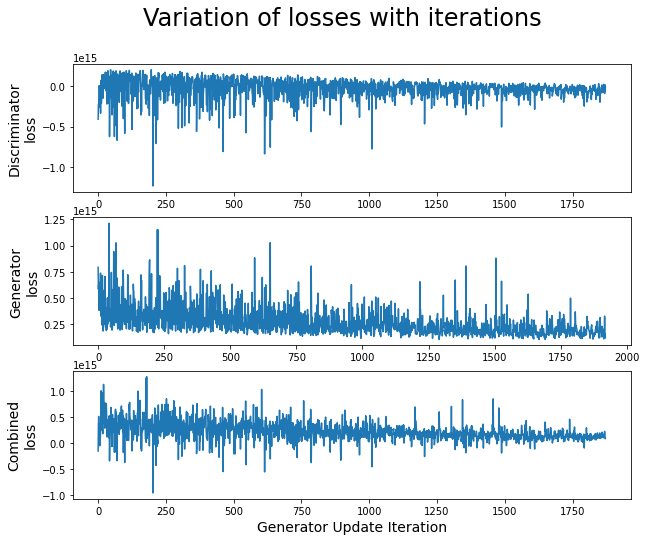

In [80]:
model.train(
    dataloader      = train_dataLoader,
    nepochs         = 10,
    ncritics        = N_CRITICS,
    sample_interval = SAMPLE_INTERVALS,
    save_interval   = SAVE_INTERVAL,
    load_states     = False,
    save_states     = True,
    verbose         = True,
    mlflow_run      = False,
    lr              = LEARNING_RATE/10,
    betas           = BETAS,
    l_gp            = 30,
    l_l1            = 0,
        
    DUMPING_INTERVAL= DUMPING_INTERVAL,
    place_to_save = 'output/training_single_sigmoid2_'+str(LATENT_DIM)+'/losses.png'
)

In [ ]:
model.plot_and_save(np.array([]), np.array([]), place_to_save='losses.png', delete_at_end=False)

tensor([-0.1118,  0.1745], device='cuda:0')


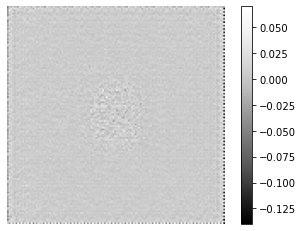

In [12]:
z = model._get_latent_vector(10)
# z = torch.rand_like(input=z, dtype=z.dtype, device=model.device)
    # Generate a batch of images
print(z[0, :])
gen_imgs = (model.generator(z)).detach().cpu()

plt.imshow((gen_imgs[0,0,:,:]), cmap='Greys_r')
plt.axis('off')
plt.colorbar()
plt.show()

tensor([-0.0638,  0.2598], device='cuda:0')


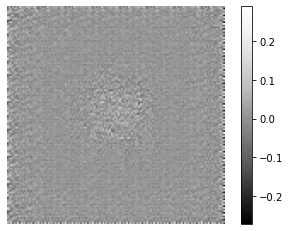

In [13]:
z = model._get_latent_vector(10)
# z = torch.rand_like(input=z, dtype=z.dtype, device=model.device)
    # Generate a batch of images
print(z[0, :])
gen_imgs = (model.generator(z)).detach().cpu()

plt.imshow((gen_imgs[0,0,:,:]), cmap='Greys_r')
plt.axis('off')
plt.colorbar()
plt.show()

In [85]:
model.save_states(pathlib.Path('.'), "current_working_06Jul2023_2")

saving states current_working_06Jul2023_2
Saved


In [ ]:
BATCHES_TO_SAVE = 80
# The numbers are read (LATENT_DIM)_(N_CONV_LATER_GEN)_(N_CONV_LATER_DISC)_(KERNEL_SIZE)_(PADDING)_(OUTPUT_PADDING)_(TRAINING_EPOCHS)
# model.save_states(pathlib.Path("."), "Single_Gaussian_Blobs_" + str(LATENT_DIM) + '_5_5_4_1_0_' + str(N_EPOCHS))
SAVING_DIR = 'datasets_for_Statistician/Full_model___second__single_blob_simple_' + str(LATENT_DIM) + '_5_5_4_1_0_' + str(N_EPOCHS) + '/generated_data/'
os.makedirs(SAVING_DIR, exist_ok=True)

for n in range(BATCHES_TO_SAVE):
    z = model._get_latent_vector(BATCH_SIZE)
    # Generate a batch of images
    gen_imgs = model.generator(z).detach().cpu()
        
    for i in range(BATCH_SIZE):
        frame = gen_imgs.numpy()[i, 0, :, :]
        frame = frame - np.min(frame)
        frame = frame * 255 / np.max(frame)
        frame = frame.astype(np.uint8)

        img = Image.fromarray(frame)# .convert('RGB')
        print(f'\r{n*BATCH_SIZE + i + 1} / {BATCHES_TO_SAVE * BATCH_SIZE}', end='')
        img.save(SAVING_DIR + str((n * BATCH_SIZE) + i) + '.jpg')    

print('\n') 

## PIXGAN Model

In [ ]:
class Generator_PIXGAN(nn.Module):
    def __init__(self, ngpu = 1) -> None:
        super().__init__()

        self.down1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features = 64,
                eps          = 0.01,
                momentum     = .9
            ),
            nn.ReLU()
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features = 128,
                eps          = 0.01,
                momentum     = .9
            ),
            nn.ReLU()
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features = 256,
                eps          = 0.01,
                momentum     = .9
            ),
            nn.ReLU()
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features = 512,
                eps          = 0.01,
                momentum     = .9
            ),
            nn.ReLU()
        )
        self.down5 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features = 512,
                eps          = 0.01,
                momentum     = .9
            ),
            nn.ReLU()
        )
        self.down6 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features = 512,
                eps          = 0.01,
                momentum     = .9
            ),
            nn.ReLU()
        )
        self.down7 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(
                num_features = 512,
                eps          = 0.01,
                momentum     = .9
            ),
            nn.ReLU()
        )

        
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 512,
                out_channels = 512,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(
                num_features = 512,
                eps          = 0.01,
                momentum     = 0.2
            ),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 512*2,
                out_channels = 512,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(
                num_features = 512,
                eps          = 0.01,
                momentum     = 0.2
            ),
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 512*2,
                out_channels = 512,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(
                num_features = 512,
                eps          = 0.01,
                momentum     = 0.2
            ),
            nn.ReLU()
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 512*2,
                out_channels = 256,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(
                num_features = 256,
                eps          = 0.01,
                momentum     = 0.2
            ),
            nn.ReLU()
        )
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 256*2,
                out_channels = 128,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(
                num_features = 128,
                eps          = 0.01,
                momentum     = 0.2
            ),
            nn.ReLU()
        )
        self.up6 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 128*2,
                out_channels = 64,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(
                num_features = 64,
                eps          = 0.01,
                momentum     = 0.2
            ),
            nn.ReLU()
        )
        self.up7 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 64*2,
                out_channels = 4,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(
                num_features = 4,
                eps          = 0.01,
                momentum     = 0.2
            ),
            nn.ReLU()
        )

        self.final_layer = nn.Sequential(
            LinearFeature(
                in_features=4,
                out_features=4
            ),
            ScaledTanh(a = 15, b=  2)
        )

        self.model = nn.Sequential(
            self.down1,
            self.down2,
            self.down3,
            self.down4,
            self.down5,
            self.down6,
            self.down7,

            self.up1,
            self.up2,
            self.up3,
            self.up4,
            self.up5,
            self.up5,
            self.up6,
            self.up7,

            self.final_layer
        )
        self.ngpu = ngpu

    def forward(self, z):
        x1 = self.down1(z)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)
        x7 = self.down7(x6)

        y1 = torch.cat([self.up1(x7), x6], dim=1)
        y2 = torch.cat([self.up2(y1), x5], dim=1)
        y3 = torch.cat([self.up3(y2), x4], dim=1)
        y4 = torch.cat([self.up4(y3), x3], dim=1)
        y5 = torch.cat([self.up5(y4), x2], dim=1)
        y6 = torch.cat([self.up6(y5), x1], dim=1)

        y7 = self.up7(y6)

        out = self.final_layer(y7)
        return out

In [ ]:
class UNetUP(nn.Module):
    def __init__(self, in_filters, out_filters, normalize, kernal_size,
                 stride, padding, output_padding, ngpu, dropout_rate=0, activation=True, use_leaky=False):
        super().__init__()
        block = [nn.ConvTranspose2d(in_filters, out_filters, kernal_size, stride=stride, padding=padding
                                    , output_padding=output_padding)]
        if normalize:
            block.append(nn.BatchNorm2d(out_filters))
        if dropout_rate != 0:
            assert (1 >= dropout_rate >= 0)
            block.append(nn.Dropout(dropout_rate))
        if activation:
            block.append(nn.ReLU(inplace=True) if not use_leaky else nn.LeakyReLU(0.2, inplace=True))
        self.model = nn.Sequential(*block)
        self.ngpu = ngpu

    def forward(self, z, skip_input):
        if z.is_cuda and self.ngpu > 0:
            ret = nn.parallel.data_parallel(self.model, z, range(self.ngpu))
        else:
            ret = self.model(z)
        if skip_input is not None:
            ret = torch.cat((ret, skip_input), 1)

        return ret

class UNetDown(nn.Module):
    def __init__(self, in_filters, out_filters, normalize, kernal_size,
                 stride, padding, ngpu, dropout_rate=0, use_leaky=True):
        super().__init__()
        block = [nn.Conv2d(in_filters, out_filters, kernal_size, stride=stride, padding=padding)]
        if dropout_rate != 0:
            assert (1 >= dropout_rate >= 0)
            block.append(nn.Dropout(dropout_rate))
        if normalize:
            block.append(nn.BatchNorm2d(out_filters))
        if use_leaky:
            block.append(nn.LeakyReLU(0.2, inplace=True))
        else:
            block.append(nn.ReLU(inplace=True))
        self.model = nn.Sequential(*block)
        self.ngpu = ngpu

    def forward(self, z):
        if z.is_cuda and self.ngpu > 0:
            ret = nn.parallel.data_parallel(self.model, z, range(self.ngpu))
        else:
            ret = self.model(z)
        return ret
    
    
class Generator_PIXGAN(nn.Module):
    def __init__(self, shape, nconv_layer=2, nconv_fc=32, ngpu=1, kernal_size=5, stride=2, padding=2,
                 output_padding=1, normalize=True, activation=None, nin_channel=1, nout_channel=1,
                 nthresh_layer=1, dropout_rate=0.5):
        super().__init__()
        self.shape = shape
        self.nconv_layer = nconv_layer
        self.normalize = normalize
        self.ngpu = ngpu
        self.nconv_fc = nconv_fc
        self.kernal_size = kernal_size
        self.stride = stride
        self.padding = padding
        self.output_padding = output_padding
        self.ds_size = shape[-1] // self.stride ** self.nconv_layer
        self.activation = activation
        self.model_dict = nn.ModuleDict()
        self.nin_channel = nin_channel
        self.nout_channel = nout_channel
        self.nthresh_layer = nthresh_layer
        self.ntotal_layer = nthresh_layer + nconv_layer
        self.dropout_rate = dropout_rate

        nconv_lc = nconv_fc * self.stride ** (self.nconv_layer - 1)
        ## define down layers
        self.model_dict["down0"] = UNetDown(self.nin_channel, nconv_fc, normalize=False, dropout_rate=0.0,
                                            kernal_size=self.kernal_size,
                                            stride=self.stride, padding=self.padding, ngpu=ngpu)
        for i in range(1, self.nconv_layer):
            self.model_dict["down%d" % (i)] = UNetDown(self.nconv_fc * self.stride ** (i - 1),
                                                       self.nconv_fc * self.stride ** i, normalize=True,
                                                       kernal_size=self.kernal_size,
                                                       stride=self.stride, padding=self.padding, ngpu=ngpu)

        ## bottom treshold layers
        for i in range(self.nthresh_layer):
            down_idx = "down%d" % (self.nconv_layer + i)
            use_leaky = i < self.nthresh_layer - 1
            normalize = i < self.nthresh_layer - 1
            self.model_dict[down_idx] = UNetDown(nconv_lc, nconv_lc, normalize=normalize, use_leaky=use_leaky,
                                                 kernal_size=self.kernal_size,
                                                 stride=self.stride, padding=self.padding, ngpu=ngpu)
        for i in range(self.nthresh_layer):
            up_idx = "up%d" % i
            upin_channel = nconv_lc if i == 0 else nconv_lc * 2
            dropout_rate = self.dropout_rate if i > 0 else 0.0
            self.model_dict[up_idx] = UNetUP(upin_channel, nconv_lc, normalize=True, dropout_rate=dropout_rate,
                                             kernal_size=self.kernal_size,
                                             stride=self.stride, padding=self.padding,
                                             output_padding=self.output_padding, ngpu=ngpu)

        ## up layers

        for i in range(self.nconv_layer + 1):
            self.model_dict["up%d" % (i + self.nthresh_layer)] = UNetUP(int(nconv_lc * self.stride ** (-i + 1)),
                                                                        int(nconv_lc * self.stride ** (-i - 1)),
                                                                        normalize=True, dropout_rate=0,
                                                                        kernal_size=self.kernal_size,
                                                                        stride=self.stride, padding=self.padding,
                                                                        output_padding=self.output_padding, ngpu=ngpu)
        self.model_dict["up%d" % (self.ntotal_layer - 1)] = UNetUP(self.nconv_fc * 2, self.nout_channel,
                                                                   normalize=False, dropout_rate=0,
                                                                   kernal_size=self.kernal_size, stride=self.stride,
                                                                   padding=self.padding,
                                                                   output_padding=self.output_padding, ngpu=ngpu,
                                                                   activation=False)
        if self.activation is not None:
            self.model_dict["final"] = nn.Sequential(*self.activation)

    def forward(self, img):
        ret = {"down-1": img}
        for i in range(self.ntotal_layer):
            input_key = "down%d" % (i - 1)
            model_key = "down%d" % (i)
            ret[model_key] = self.model_dict[model_key](ret[input_key])
        ret.pop("down-1")
        ret_up = ret[model_key]

        for i in range(self.ntotal_layer):
            skip_key = "down%d" % (self.ntotal_layer - 2 - i)
            model_key = "up%d" % (i)
            ret_up = self.model_dict[model_key](ret_up, ret[skip_key] if skip_key in ret else None)
        return ret_up if "final" not in self.model_dict else self.model_dict["final"](ret_up)

In [ ]:
gen = Generator_PIXGAN(shape=(1,128,128))
print("gen created")

z = np.random.uniform(0, 1, (10, 1, 128, 128))
z = torch.FloatTensor(z)
gen_img = gen.forward(z).detach().cpu().numpy()
print("10 images output size:", gen_img.shape)

plt.figure(dpi=150)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(gen_img[i, 0, :, :])
    plt.colorbar()
    plt.axis('off')
plt.show()

In [ ]:
class Discriminator_PIXGAN(Discriminator_Basic):
    def __init__(self, shape, nconv_layer=2, nconv_fc=32, ngpu=1, kernal_size=5, stride=2, padding=2, normalize=True,
                 nthresh_layer=1):
        self.nthresh_layer = nthresh_layer
        super().__init__()

    def get_last_layer(self):
        layers = []
        for i in range(self.nthresh_layer):
            nin_filt = self.nconv_fc * self.stride ** ((self.nconv_layer - 2) + 1) if i == 0 else 512
            layers.extend(self.discriminator_block(nin_filt, 512, stride=1, normalize=True))
        layers.extend([nn.Conv2d(512, 1, self.kernal_size, stride=1, padding=self.padding), nn.Sigmoid()])
        return layers

In [ ]:
class GAN_PIXGAN(GAN_Basic):
    def __init__(self, identifier, shape, output_path=None, experiment_path=None, cuda=False, ngpu=1,
                 nconv_layer_gen=2, nconv_layer_disc=2, nconv_fcgen=32, nconv_fcdis=32, kernal_size=5, stride=2,
                 padding=2, output_padding=1, gen_act=[nn.Tanh()], nin_channel=3, nout_channel=3, nthresh_layer_gen=1,
                 nthresh_layer_disc=1, dropout_rate=0.5):
        super().__init__(identifier, latent_dim=1,
                         cuda=cuda, ngpu=ngpu)
        
        self.nconv_layer_gen = nconv_layer_gen
        self.nconv_layer_disc = nconv_layer_disc
        self.nconv_fcgen = nconv_fcgen
        self.nconv_fcdis = nconv_fcdis
        
        _root = os.path.dirname(os.path.abspath('./code'))
        self.output_path = os.path.join(os.path.join(_root, "output"))
        self.experiment_path = os.path.join(self.output_path, identifier)

        self.nin_channel = nin_channel
        self.nout_channel = nout_channel
        self.model_params.update({"nconv_layer_gen": self.nconv_layer_gen, "nconv_layer_disc": self.nconv_layer_disc,
                                  "nconv_fcgen": self.nconv_fcgen, "nconv_fcdis": self.nconv_fcdis,
                                  "kernal_size": kernal_size, "nin_channel": self.nin_channel,
                                  "nout_channel": self.nout_channel,
                                  "stride": stride, "padding": padding, "output_padding": output_padding,
                                  "nthresh_layer_gen": nthresh_layer_gen, "nthresh_layer_disc": nthresh_layer_disc,
                                  "gen_act": str([i.__class__.__name__ for i in gen_act]),
                                  "dropout_rate": dropout_rate})

        self.generator = Generator_PIXGAN(shape, 
                                        nconv_layer=self.nconv_layer_gen, nconv_fc=self.nconv_fcgen,
                                        ngpu=self.ngpu,
                                        kernal_size=kernal_size, 
                                        stride=stride, 
                                        padding=padding,
                                        output_padding=output_padding, normalize=True,
                                        activation=gen_act, nin_channel=self.nin_channel,
                                        nout_channel=self.nout_channel,
                                        nthresh_layer=nthresh_layer_gen, 
                                        dropout_rate=dropout_rate).to(device=self.device)
        self.discriminator = Discriminator_PIXGAN(shape, nconv_layer=self.nconv_layer_disc, nconv_fc=self.nconv_fcdis,
                                                ngpu=self.ngpu,
                                                kernal_size=kernal_size, stride=stride, padding=padding, normalize=True,
                                                nthresh_layer=nthresh_layer_disc).to(device=self.device)
        # Initialize weights
        self.generator.apply(self._weights_init_normal)
        self.discriminator.apply(self._weights_init_normal)
        # nn.BCELoss()

        # self.adversarial_loss = nn.BCELoss().to(device=self.device)
        self.adversarial_loss = nn.BCEWithLogitsLoss().to(device=self.device)
        # self.l1_loss = torch.nn.L1Loss().to(device=self.device)  # nn.MSELoss().to(device=self.device)

    def _eval_generator_loss(self, real_imgs, gen_imgs, **kwargs):
        gen_disc = self.discriminator(gen_imgs)
        valid = Variable(self.Tensor(gen_disc.shape).fill_(1.0), requires_grad=False)
        l1_loss = self.l1_loss(real_imgs, gen_imgs)
        return self.adversarial_loss(gen_disc, valid) + kwargs["lambda_l1"] * l1_loss

    def _eval_discriminator_loss(self, real_imgs, gen_imgs, **kwargs):
        gen_disc = self.discriminator(gen_imgs)
        valid = Variable(self.Tensor(gen_disc.shape).fill_(1.0), requires_grad=False)
        fake = Variable(self.Tensor(gen_disc.shape).fill_(0.0), requires_grad=False)
        labels = (fake, valid) if self._flip_label() else (valid, fake)
        real_loss = self.adversarial_loss(self.discriminator(real_imgs), labels[0])
        fake_loss = self.adversarial_loss(gen_disc, labels[1])
        # l1_loss = self.l1_loss(real_imgs, gen_imgs)

        return (real_loss + fake_loss) / 2  # + kwargs["lambda_l1"]*l1_loss

    def generate_samples(self, input_imgs, concat=False, train=False):
        if input_imgs.ndim == 3: input_imgs = input_imgs[np.newaxis, ...]
        if not train:
            self.generator.eval()
            self.discriminator.eval()
        else:
            self.generator.train()
            self.discriminator.train()
        input_imgs = Variable(self.Tensor(input_imgs[:, :self.nin_channel, ...]))
        ret = self.generator(input_imgs).detach()
        if concat:
            ret = torch.cat((input_imgs, ret), 1)
        return ret

    def train(self, dataloader, nepochs=200, ncritics=5, sample_interval=1000,
              save_interval=10000, load_states=True, save_states=True, verbose=True, mlflow_run=None,
              lr = 1e-4, betas=(0.5, 0.999),
              disc_conditional=True, **kwargs):
        kwargs.update({"nepochs": nepochs, "ncritics": ncritics, "disc_conditional": disc_conditional})
        kwargs.update(self.model_params)

        # Base Setup
        run_id = "trial" if not mlflow_run else mlflow_run.info.run_id
        run_path = os.path.join(self.experiment_path, run_id)
        artifacts_path = os.path.join(run_path, "artifacts")
        model_path = os.path.join(run_path, "model")
        self.generator.train()
        self.discriminator.train()

        os.makedirs(artifacts_path, exist_ok=True)
        os.makedirs(model_path, exist_ok=True)
        if load_states:
            self.load_states(model_path)

        self.save_states(model_path, 0)
        # Get Optimizers
        opt_gen, opt_disc = self._get_optimizers(lr, betas)
        batches_done = 0
        for epoch in range(nepochs):

            for i, sample in enumerate(dataloader):
                imgs = sample[0]
                input_imgs = Variable(imgs[:, :self.nin_channel, ...].type(self.Tensor))
                real_imgs_cat = Variable(
                    imgs.type(self.Tensor) if disc_conditional else imgs[:, self.nin_channel:, ...].type(self.Tensor))

                opt_disc.zero_grad()
                # Generate a batch of images
                gen_imgs = self.generator(input_imgs)
                gen_imgs_cat = torch.cat((input_imgs, gen_imgs), 1).detach() if disc_conditional else gen_imgs.detach()

                # Adversarial loss 
                loss_D = self._eval_discriminator_loss(real_imgs_cat, gen_imgs_cat, **kwargs)
                loss_D.backward()
                opt_disc.step()

                # Hook for Discriminator Post Processing
                self._post_process_discriminator(**kwargs)
                if i % ncritics == 0:
                    opt_gen.zero_grad()

                    real_imgs_cat = Variable(
                        imgs.type(self.Tensor) if disc_conditional else imgs[:, self.nin_channel:, ...].type(
                            self.Tensor))
                    # Generate a batch of images
                    gen_imgs = self.generator(input_imgs)
                    gen_imgs_cat = torch.cat((input_imgs, gen_imgs), 1) if disc_conditional else gen_imgs
                    # Adversarial loss\
                    loss_G = self._eval_generator_loss(real_imgs_cat, gen_imgs_cat, **kwargs)

                    loss_G.backward()
                    opt_gen.step()
                    if verbose:
                        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                              % (epoch, nepochs, batches_done % len(dataloader), len(dataloader), loss_D.item(),
                                 loss_G.item())
                              )
                if batches_done % sample_interval == 0:
                    if disc_conditional:
                        temp = torch.cat((real_imgs_cat.data[:1, self.nin_channel:, ...],
                                          gen_imgs_cat.data[:5, self.nin_channel:, ...]), 0)
                    else:
                        temp = torch.cat((real_imgs_cat.data[:1, ...], gen_imgs_cat.data[:5, ...]), 0)
                    temp = temp if gen_imgs_cat.shape[-3] < 4 else torch.unsqueeze(torch.sum(temp, 1), 1)
                    save_image(temp, os.path.join(artifacts_path, "%d.png" % batches_done), normalize=True,
                               nrow=int(temp.shape[0] / 2.))
                batches_done += 1

            if int(epoch + 1) % save_interval == 0 and save_states:
                self.save_states(model_path, int(epoch + 1))
        if save_states:
            self.save_states(model_path, nepochs)


In [ ]:
LATENT_DIM = 2
print("Size of latent random vector:", LATENT_DIM)
model = GAN_PIXGAN(
            identifier="pixgan_290623", 
            shape = (5,128,128), 
            nconv_fcgen=64,
            nconv_fcdis=64, 
            cuda=torch.cuda.is_available(), ngpu=4, 
            nconv_layer_gen=4, nconv_layer_disc=3, 
            kernal_size=4,
            stride=2,
            padding=1, 
            output_padding=0, 
            gen_act=[ScaledTanh()], 
            nin_channel=1, 
            nout_channel=4, 
            nthresh_layer_gen=3, 
            nthresh_layer_disc=2
        )


In [ ]:
torch.cuda.empty_cache()


In [ ]:
model.train(
        train_dataLoader,
        nepochs=1,
        ncritics=1,
        sample_interval=SAMPLE_INTERVALS,
        save_interval= SAVE_INTERVAL,
        load_states=True,
        save_states=True,
        verbose=True,
        lr=2e-4,
        betas=(0.5, 0.999),
        l_l1=100.
)

In [ ]:
model.load_states(pathlib.Path('.'), '6_PIXGAN')